In [1]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.visualize import PWEVisualization
from PW_explorer.helper import pw_slicer, rel_slicer, rel_name_remapper
from PW_explorer.export import PWEExport
import pandas as pd

In [2]:
import networkx as nx
from nxpd import draw
import nxpd
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [3]:
from misc import *

In [4]:
%load_ext PWE_NB_Extension

In [5]:
%%clingo --donot-display_input -lci qep_eq_check2 --donot-run

% e(X,Y) :- e(Y,X). --> only if undirected
gnode1(X) :- e1(X,_).
gnode1(X) :- e1(_,X).
gnode1(X) :- ne1(X,_).
gnode1(X) :- ne1(_,X).

gnode2(X) :- e2(X,_).
gnode2(X) :- e2(_,X).
gnode2(X) :- ne2(X,_).
gnode2(X) :- ne2(_,X).

vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).
:- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), not e2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not e1(X1,X2), e2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), ne1(X1,X2), not ne2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not ne1(X1,X2), ne2(Y1,Y2).

% 3hop Query

:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), vmap(X4,Y4), thop1(X1,X2,X3,X4), not thop2(Y1,Y2,Y3,Y4).
:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), vmap(X4,Y4), not thop1(X1,X2,X3,X4), thop2(Y1,Y2,Y3,Y4).

:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), thop1(X1,X2,X3), not thop2(Y1,Y2,Y3).
:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), not thop1(X1,X2,X3), thop2(Y1,Y2,Y3).

:- vmap(X1,Y1), vmap(X2,Y2), thop1(X1,X2), not thop2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not thop1(X1,X2), thop2(Y1,Y2).

:- vmap(X1,Y1), thop1(X1), not thop2(Y1).
:- vmap(X1,Y1), not thop1(X1), thop2(Y1).

:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), vmap(X4,Y4), nthop1(X1,X2,X3,X4), not nthop2(Y1,Y2,Y3,Y4).
:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), vmap(X4,Y4), not nthop1(X1,X2,X3,X4), nthop2(Y1,Y2,Y3,Y4).

:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), nthop1(X1,X2,X3), not nthop2(Y1,Y2,Y3).
:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), not nthop1(X1,X2,X3), nthop2(Y1,Y2,Y3).

:- vmap(X1,Y1), vmap(X2,Y2), nthop1(X1,X2), not nthop2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not nthop1(X1,X2), nthop2(Y1,Y2).

:- vmap(X1,Y1), nthop1(X1), not nthop2(Y1).
:- vmap(X1,Y1), not nthop1(X1), nthop2(Y1).


% Triangle Query

:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), tri1(X1,X2,X3), not tri2(Y1,Y2,Y3).
:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), not tri1(X1,X2,X3), tri2(Y1,Y2,Y3).

:- vmap(X1,Y1), vmap(X2,Y2), tri1(X1,X2), not tri2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not tri1(X1,X2), tri2(Y1,Y2).

:- vmap(X1,Y1), tri1(X1), not tri2(Y1).
:- vmap(X1,Y1), not tri1(X1), tri2(Y1).

:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), ntri1(X1,X2,X3), not ntri2(Y1,Y2,Y3).
:- vmap(X1,Y1), vmap(X2,Y2), vmap(X3,Y3), not ntri1(X1,X2,X3), ntri2(Y1,Y2,Y3).

:- vmap(X1,Y1), vmap(X2,Y2), ntri1(X1,X2), not ntri2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not ntri1(X1,X2), ntri2(Y1,Y2).

:- vmap(X1,Y1), ntri1(X1), not ntri2(Y1).
:- vmap(X1,Y1), not ntri1(X1), ntri2(Y1).



% used1(X) :- vmap(X,_).
% :- gnode(X), not used1(X).
% :- vmap(X,Y),vmap(X,Z),Y!=Z.
% :- vmap(Y,X),vmap(Z,X),Y!=Z.

:- gnode1(X), #count {Y: vmap(X,Y)} != 1.
:- gnode2(Y), #count {X: vmap(X,Y)} != 1.

#show.
% #show vmap/2.

In [6]:
def are_equivalent_patterns(pw1, pw2, eq_check_encoding=qep_eq_check2):
    
    def get_edge_facts(pw, edge_rel_idx):
        pw_objs = [pw]
        _,_,pw_objs = rel_slicer(None, None, pw_objs, rels_to_use=['e_2', 'ne_2'])
        _, pw_objs, _ = rel_name_remapper(None, pw_objs, None, rel_name_map={'e_2': 'e{}_2'.format(str(edge_rel_idx)),
                                                                             'ne_2': 'ne{}_2'.format(str(edge_rel_idx))})
        return PWEExport.export_as_asp_facts(pw_objs, include_pw_ids=False)
    
    pw1_edge_facts = get_edge_facts(pw1, 1)
    pw2_edge_facts = get_edge_facts(pw2, 2)
    pw1_head_facts = get_query_head_facts(pw1, idx=1)
    pw2_head_facts = get_query_head_facts(pw2, idx=2)
    # print(pw1_edge_facts, pw2_edge_facts)
    asp_out, _ = run_clingo(eq_check_encoding.split('\n')+pw1_edge_facts+pw2_edge_facts+pw1_head_facts+pw2_head_facts, num_solutions=1)
    # print(asp_out)
    _,_,eq_check_pws = load_worlds(asp_out, silent=True)
    
    return len(eq_check_pws) >= 1

In [7]:
%%clingo --donot-display_input -lci query_analysis_starter --donot-run

% TO ADD
% schema var(VAR, DOMAIN).
% schema ruleOcc(ATOM, OCC).
% schema ruleH(HEAD).
% schema arc(VAR, POS, ATOM, OCC).
% schema hArc(VAR, POS, HEAD).


% schema ruleOccTrue(ATOM, OCC)
ruleOccTrue(R, OC) ; not ruleOccTrue(R, OC) :- ruleOcc(R, OC).

% schema ruleHTrue(HEAD)
ruleHFalse(H) :- ruleH(H), ruleOcc(R, OCC), not ruleOccTrue(R,OCC).
ruleHTrue(H)  :- ruleH(H), not ruleHFalse(H).

% schema eq(VAR1, VAR2, DOMAIN)
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.
% schema newVar(VAR, DOMAIN)
newVar(VAR, TYPE) :- var(VAR, TYPE), not eqOrd(_,VAR,TYPE).
% schema eqOrdMinimal(VAR1, VAR2, DOMAIN)
eqOrdMinimal(A,B,TYPE) :- eqOrd(A,B,TYPE), newVar(A,TYPE).
% schema neqOrd(VAR1, VAR2, DOMAIN)
neqOrd(A,B,TYPE) :- newVar(A,TYPE), newVar(B,TYPE), A<B.

% Find the new arcs, getting rid of the redundancies

% schema newArc(VAR, POS, ATOM, OCC)
newArc(VAR, POS, ATOM, OCC) :- arc(VAR_ORIG, POS, ATOM, OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM, OCC) :- arc(VAR, POS, ATOM, OCC), not eqOrd(_,VAR,_).

% schema newHArc(VAR, POS, HEAD)
newHArc(VAR, POS, H) :- hArc(VAR_ORIG,POS,H), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newHArc(VAR, POS, H) :- hArc(VAR, POS, H), not eqOrd(_,VAR,_).

% It cannot be true that eX and eY have the same variable assignments but one is True while other is False
:- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), newArc(V1, 1, "e", OCC2), newArc(V2, 2, "e", OCC2), ruleOccTrue("e", OCC1), not ruleOccTrue("e", OCC2). 

% New inferred edges
% schema e(NODE1, NODE2)
e(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% schema e(OCC, NODE1, NODE2)
e(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% New inferred missing edges
% schema ne(NODE1, NODE2)
ne(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).

% schema ne(OCC, NODE1, NODE2)
ne(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).


%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green


#show ruleOccTrue/2.
#show var/2.
#show newVar/2.
#show ruleOcc/2.
#show ruleH/1.
#show eqOrd/3.
#show neqOrd/3.
#show eqOrdMinimal/3.
#show arc/4.
#show newArc/4.
#show hArc/3.
#show newHArc/3.
#show e/2.
#show ne/2.
#show e/3.
#show ne/3.
#show eqAtomOccOrd/3.
#show fAtom/3.
#show ruleHTrue/1.

In [8]:
%%clingo --donot-display_input -l query_analysis_starter -exp query_analysis

% thop(X,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y).

var("X", node).
var("Y", node).
var("Z1", node).
var("Z2", node).

ruleOcc("e", 1..3).

ruleH("thop").

arc("X",  1, "e", 1).
arc("Z1", 2, "e", 1).
arc("Z1", 1, "e", 2).
arc("Z2", 2, "e", 2).
arc("Z2", 1, "e", 3).
arc("Y",  2, "e", 3).


% Use the rules below to change the rule head.
hArc("X", 1, "thop") :- ruleH("thop").
hArc("Y", 2, "thop") :- ruleH("thop").
% hArc("Z1", 3, "thop") :- ruleH("thop").
% hArc("Z2", 4, "thop") :- ruleH("thop").

:- not ruleHTrue("thop"). % --> Use to generate only the success patterns


Output:


'Answer: 1\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("Y",2,"thop") hArc("X",1,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") newArc("Z1",2,"e",1) newArc("Z1",1,"e",2) newArc("Z2",2,"e",2) newArc("Z2",1,"e",3) newArc("Y",2,"e",3) e(1,"X","Z1") e(2,"Z1","Z2") e(3,"Z2","Y") e("X","Z1") e("Z1","Z2") e("Z2","Y") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z1",node) newVar("Z2",node) neqOrd("X","Y",node) neqOrd("X","Z1",node) neqOrd("Y","Z1",node) neqOrd("X","Z2",node) neqOrd("Y","Z2",node) neqOrd("Z1","Z2",node)\nAnswer: 2\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("Y",2,"thop") hArc("X",1,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Y","Z2",node) newArc("Y",2,"e",2) newArc("Y",1,"e",3) newArc("Z1",2,"e",1) newArc("Z1",1,"e",2) newArc("Y",2,"e",3) e(1,"X","Z1") e(2,"Z1","Y") e(3,"Y","Y") e("X","Z1") e("Y","Y") e("Z1","Y") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z1",node) neqOrd("X","Y",node) neqOrd("X","Z1",node) neqOrd("Y","Z1",node) eqOrdMinimal("Y","Z2",node)\nAnswer: 3\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("Y",2,"thop") hArc("X",1,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Y","Z1",node) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Z2",2,"e",2) newArc("Z2",1,"e",3) newArc("Y",2,"e",3) e(1,"X","Y") e(2,"Y","Z2") e(3,"Z2","Y") e("X","Y") e("Y","Z2") e("Z2","Y") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z2",node) neqOrd("X","Y",node) neqOrd("X","Z2",node) neqOrd("Y","Z2",node) eqOrdMinimal("Y","Z1",node)\nAnswer: 4\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("Y",2,"thop") hArc("X",1,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Z1","Z2",node) newArc("Z1",2,"e",2) newArc("Z1",1,"e",3) newArc("Z1",2,"e",1) newArc("Z1",1,"e",2) newArc("Y",2,"e",3) e(1,"X","Z1") e(2,"Z1","Z1") e(3,"Z1","Y") e("X","Z1") e("Z1","Y") e("Z1","Z1") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z1",node) neqOrd("X","Y",node) neqOrd("X","Z1",node) neqOrd("Y","Z1",node) eqOrdMinimal("Z1","Z2",node)\nAnswer: 5\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("Y",2,"thop") hArc("X",1,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Y","Z1",node) eqOrd("Y","Z2",node) eqOrd("Z1","Z2",node) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Y",2,"e",2) newArc("Y",1,"e",3) newArc("Y",2,"e",3) e(1,"X","Y") e(2,"Y","Y") e(3,"Y","Y") e("X","Y") e("Y","Y") newHArc("Y",2,"thop") newVar("Y",node) neqOrd("X","Y",node) eqOrdMinimal("Y","Z1",node) eqOrdMinimal("Y","Z2",node)\nAnswer: 6\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("Y",2,"thop") hArc("X",1,"t

In [9]:
query_analysis['pw_rel_dfs'], query_analysis['rel_schema'], query_analysis['pw_objs'] =load_worlds(query_analysis['asp_soln'],
                                                                                                   query_analysis['meta_data'])


Number of Models: 15


In [10]:
if 'hArc_3' not in query_analysis['pw_rel_dfs']:
    query_analysis['pw_rel_dfs']['hArc_3'] = pd.DataFrame(columns=['pw', 'VAR', 'POS', 'HEAD'])
if 'newHArc_3' not in query_analysis['pw_rel_dfs']:
    query_analysis['pw_rel_dfs']['newHArc_3'] = pd.DataFrame(columns=['pw', 'VAR', 'POS', 'HEAD'])
for i in range(len(query_analysis['pw_objs'])):
    if 'hArc_3' not in query_analysis['pw_objs'][i].rls:
        query_analysis['pw_objs'][i].rls['hArc_3'] = []
    if 'newHArc_3' not in query_analysis['pw_objs'][i].rls:
        query_analysis['pw_objs'][i].rls['newHArc_3'] = []
    if 'ruleHTrue_1' not in query_analysis['pw_objs'][i].rls:
        query_analysis['pw_objs'][i].rls['ruleHTrue_1'] = []

In [11]:
for i in range(1, len(query_analysis['pw_objs'])+1):
    print("\nPW:", i)
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]        

#     g = get_incidence_graph(pw_rel_dfs)
#     display(draw(g))
#     print_colored_query_string(pw_rel_dfs)
    print_rewritten_query_string(pw_rel_dfs)
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=True)
    print_fancy_rewrite(pw_rel_dfs)
    
#     g = get_pattern_graph2(pw_rel_dfs)
#     draw(g, format='pdf', filename='{}.{}'.format('3hop_all_patterns/pw_{}'.format(i), 'pdf'), show='none')
#     display(draw(g))


PW: 1



PW: 2



PW: 3



PW: 4



PW: 5



PW: 6



PW: 7



PW: 8



PW: 9



PW: 10



PW: 11



PW: 12



PW: 13



PW: 14



PW: 15


In [12]:
# Can be used directly
for i in range(1, len(query_analysis['pw_objs'])+1):
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]        
    print_rewritten_query_string(pw_rel_dfs)

In [13]:
# Can be used directly
for i in range(1, len(query_analysis['pw_objs'])+1):
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]        
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)

In [14]:
# CANNOT be used directly
for i in range(1, len(query_analysis['pw_objs'])+1):
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]        
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=True)

In [15]:
# CANNOT be used directly
for i in range(1, len(query_analysis['pw_objs'])+1):
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]        
    print_fancy_rewrite(pw_rel_dfs)

In [17]:
# are_equivalent_patterns(query_analysis['pw_objs'][5], query_analysis['pw_objs'][6], eq_check_encoding=qep_eq_check2)

In [18]:
sets = get_equivalent_sets(query_analysis['pw_objs'], are_equivalent_patterns)

In [19]:
for s in sets:
    print({pw.pw_id for pw in s})

{1}
{2}
{3}
{4}
{5}
{6}
{7}
{8}
{9}
{10}
{11}
{12}
{13, 14}
{15}


In [20]:
len(sets)

14

In [21]:
# for i, s in enumerate(sets):
#     print("\n\n\nSet:", i+1, '({})'.format(len(s)))
#     for j, pw in enumerate(s):
#         print("\nPW:", pw.pw_id)
#         pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [pw.pw_id])[0]
#         # print_colored_query_string(pw_rel_dfs)
#         # print_rewritten_query_string(pw_rel_dfs)
#         # print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)
#         # print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=True)
#         print_fancy_rewrite(pw_rel_dfs)
#         g = get_pattern_graph2(pw_rel_dfs, no_node_labels=False)
#         display(draw(g))
#         # draw(g, format='pdf', filename='{}.{}'.format('tri_eq_patterns/set_{}'.format(i+1), 'pdf'), show='none')
#         break

Set: 1 (1)
Success Pattern:


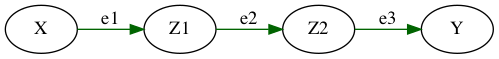

------------------------------------------------------------
Set: 2 (1)
Success Pattern:


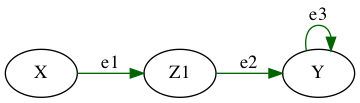

------------------------------------------------------------
Set: 3 (1)
Success Pattern:


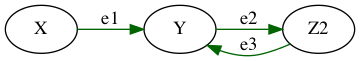

------------------------------------------------------------
Set: 4 (1)
Success Pattern:


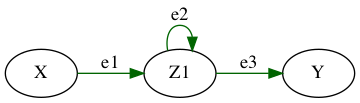

------------------------------------------------------------
Set: 5 (1)
Success Pattern:


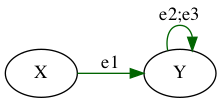

------------------------------------------------------------
Set: 6 (1)
Success Pattern:


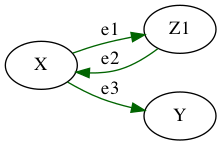

------------------------------------------------------------
Set: 7 (1)
Success Pattern:


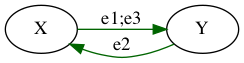

------------------------------------------------------------
Set: 8 (1)
Success Pattern:


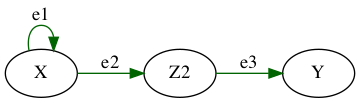

------------------------------------------------------------
Set: 9 (1)
Success Pattern:


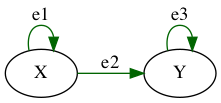

------------------------------------------------------------
Set: 10 (1)
Success Pattern:


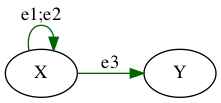

------------------------------------------------------------
Set: 11 (1)
Success Pattern:


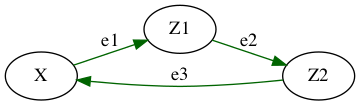

------------------------------------------------------------
Set: 12 (1)
Success Pattern:


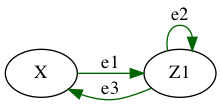

------------------------------------------------------------
Set: 13 (2)
Success Pattern:


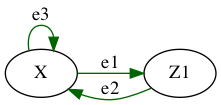

Success Pattern:


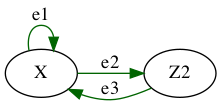

------------------------------------------------------------
Set: 14 (1)
Success Pattern:


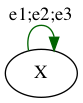

------------------------------------------------------------


In [22]:
num_patterns = 0
for i,s in enumerate(sets):
    s = list(s)
    eg = s[0]
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [eg.pw_id])[0]
    true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
    if True:#len(true_heads) > 0:
        num_patterns += 1
        print("Set:", num_patterns, '({})'.format(len(s)))
    
        for j, pw in enumerate(s):
            pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [pw.pw_id])[0]
            true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
            g = get_pattern_graph2(pw_rel_dfs, no_node_labels=False)
            # draw(g, format='pdf', filename='{}.{}'.format('3hop_eq_success_patterns/set_{}'.format(num_patterns), 'pdf'), show='none')
            display(draw(g))
            #print_rewritten_query_string(pw_rel_dfs)
            #print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)
            #print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=True)
            print_fancy_rewrite(pw_rel_dfs)
            
        print('-'*60)
# num_patterns

In [23]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop1(X,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y), X != Y, X != Z1, Y != Z1, X != Z2, Y != Z2, Z1 != Z2.
thop2(X,Y) :- e(X,Z1), e(Z1,Y), e(Y,Y), X != Y, X != Z1, Y != Z1.
thop3(X,Y) :- e(X,Y), e(Y,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop4(X,Y) :- e(X,Z1), e(Z1,Z1), e(Z1,Y), X != Y, X != Z1, Y != Z1.
thop5(X,Y) :- e(X,Y), e(Y,Y), e(Y,Y), X != Y.
thop6(X,Y) :- e(X,Z1), e(Z1,X), e(X,Y), X != Y, X != Z1, Y != Z1.
thop7(X,Y) :- e(X,Y), e(Y,X), e(X,Y), X != Y.
thop8(X,Y) :- e(X,X), e(X,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop9(X,Y) :- e(X,X), e(X,Y), e(Y,Y), X != Y.
thop10(X,Y) :- e(X,X), e(X,X), e(X,Y), X != Y.
thop11(X,X) :- e(X,Z1), e(Z1,Z2), e(Z2,X), X != Z1, X != Z2, Z1 != Z2.
thop12(X,X) :- e(X,Z1), e(Z1,Z1), e(Z1,X), X != Z1.
thop13(X,X) :- e(X,Z1), e(Z1,X), e(X,X), X != Z1.
thop14(X,X) :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop15(X,X) :- e(X,X), e(X,X), e(X,X).

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop5(b,a) thop6(b,c) thop7(a,b) thop7(b,a) thop8(a,c) thop10(a,b) thop12(b,b) thop13(a,a) thop14(a,a) thop15(a,a)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'